In [1]:
%load_ext autoreload

In [291]:
%autoreload
import torch
import torch.nn as nn
import torchvision
import numpy as np
from gpt.model import ViT, Lambda, LightningWrapper
from gpt.alt_model import ViT as AltViT
from gpt.data import MNISTDataModule, CIFAR10DataModule
from tqdm.auto import tqdm
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from rich.progress import track

In [256]:
mnist = MNISTDataModule(root_dir='/mnt/home/jshen/ceph/data/ml', num_workers=4, batch_size=8)
mnist.setup()

In [280]:
tl = mnist.test_dataloader()

In [281]:
x, y = next(iter(tl))

In [259]:
model = LightningWrapper.load_from_checkpoint('../train/lightning_logs/version_2957798/checkpoints/epoch=32-step=3894.ckpt')

/mnt/home/jshen/miniconda3/envs/main/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'output_head' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_head'])`.


In [260]:
# model.load_state_dict(state_dict)
model.eval();
model.freeze()

In [261]:
def show(imgs, **kwargs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), **kwargs)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(None, tensor([5, 9, 0, 6, 9, 0, 1, 5]))

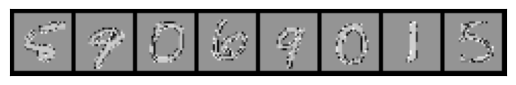

In [273]:
show(torchvision.utils.make_grid(x)), y

In [274]:
x.shape

torch.Size([8, 1, 28, 28])

In [293]:
score = 0
total = 0
for x, y in track(tl, total=len(tl)):
    with torch.no_grad():
        out = model(x)
        pred = torch.argmax(out, 1)
    score += torch.sum(pred == y)
    total += x.shape[0]

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:03:32

In [294]:
score / total

tensor(0.7829)